<div class="row">
  <div class="column">
    <img src="./img/logo-onera.png" width="200">
  </div>
  <div class="column">
    <img src="./img/logo-ISAE_SUPAERO.png" width="200">
  </div>
</div>

# FAST-OAD-GA Analysis mode Tutorial

FAST-OAD-GA is an add-on package for [FAST-OAD framework](https://github.com/fast-aircraft-design/FAST-OAD) for performing rapid Overall Aircraft Design in the category General Aviation (GA). The computational core of FAST-OAD being based on the  [OpenMDAO framework](https://openmdao.org/).

This notebook will show you the basic step to use the load analysis module using ID's to call the module and configuration files instead of importing the classes.

To organize our work, we propose to use two user folders `data/` and `workdir/`. In `data/` we store the XML file which describes the aircraft to analyse, here the Beechcraft Duchess. In `workdir/`, we store files generated or modified by FAST-OAD-(GA).

In [1]:
import os.path as pth
import os
import logging
import shutil
import openmdao.api as om
import fastoad.api as oad

import fastga.utils.postprocessing.post_processing_api as api_plots
from fastga.command import api as api_cs23

# Define relative path
DATA_FOLDER_PATH = "data"
WORK_FOLDER_PATH = "workdir"

# Final file names
AIRCRAFT_FILE = pth.join(WORK_FOLDER_PATH, "beechcraft_76_loads.xml")

In [2]:
# Clear work folder
shutil.rmtree(WORK_FOLDER_PATH, ignore_errors=True)
os.mkdir(WORK_FOLDER_PATH)

# For using all screen width
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

## 1. Read, modify and save different aircraft geometry configurations

In this paragraph we will first run the geometry module on the aircraft to derive primary parameters into the detailed geometry set.

**This process can be done using the api generate block analysis method to get this working such as a python function:**
1. Create a dictionnary with the options for your module
2. Generate a block analysis using the module id

In [3]:
# Copy reference aircraft file in work directory
shutil.copy(pth.join(DATA_FOLDER_PATH, "beechcraft_76_loads.xml"), AIRCRAFT_FILE)

# Define the wing primary geometry parameters name as a list
var_inputs = [
    "data:geometry:wing:area",
    "data:geometry:wing:aspect_ratio",
    "data:geometry:wing:taper_ratio",
]

# Define the option of the geometry module you want to use (not putting any will use the default value when
# available)
option_dict = {"propulsion_id": "fastga.wrapper.propulsion.basicIC_engine"}

# Declare function
compute_geometry = api_cs23.generate_block_analysis(
    "fastga.geometry.legacy",
    var_inputs,
    str(AIRCRAFT_FILE),
    options=option_dict,
    overwrite=True,
)

Failed to import module fastga.models.propulsion.fuel_propulsion.basicIC_engine.unitary_tests
Failed to import module fastga.models.performances.unitary_tests
Failed to import module fastga.models.handling_qualities.unitary_tests
Failed to import module fastga.models.weight.mass_breakdown.unitary_tests
Failed to import module fastga.models.propulsion.fuel_propulsion.basicTurbo_prop_map.unitary_tests
Failed to import module fastga.models.weight.cg.unitary_tests
Failed to import module fastga.models.aerodynamics.unitary_tests
Failed to import module fastga.models.propulsion.fuel_propulsion.basicTurbo_prop.unitary_tests
Failed to import module fastga.models.load_analysis.unitary_tests
Failed to import module fastga.models.loops.unitary_tests
Failed to import module fastga.models.geometry.unitary_tests


It is also possible to specify a configuration file as the input of the generate_block_analysis function, allowing to turn an OpenMDAO problem into a function. This will be showcased in the next cell but won't be reused afterwards.

In [4]:
# Copy the configuration file which contains the same models as in the previous cell
GEOMETRY_CONFIGURATION_FILE = pth.join(WORK_FOLDER_PATH, "geometry.yml")
shutil.copy(pth.join(DATA_FOLDER_PATH, "geometry.yml"), GEOMETRY_CONFIGURATION_FILE)

# Declare function
compute_geometry_yml = api_cs23.generate_block_analysis(
    GEOMETRY_CONFIGURATION_FILE,
    var_inputs,
    str(AIRCRAFT_FILE),
    overwrite=False,
)

Now we can use the previously created function to calculate the aircraft.

In [5]:
# Fetch reference aircraft values using a feature from FAST-OAD-core
reference_aircraft = oad.DataFile(AIRCRAFT_FILE)

wing_area = reference_aircraft["data:geometry:wing:area"].value[0]
wing_area_units = reference_aircraft["data:geometry:wing:area"].units

aspect_ratio = reference_aircraft["data:geometry:wing:aspect_ratio"].value[0]
aspect_ratio_units = reference_aircraft["data:geometry:wing:aspect_ratio"].units

taper_ratio = reference_aircraft["data:geometry:wing:taper_ratio"].value[0]
taper_ratio_units = reference_aircraft["data:geometry:wing:taper_ratio"].units

# Compute geometry
inputs_dict = {
    "data:geometry:wing:area": (wing_area, wing_area_units),
    "data:geometry:wing:aspect_ratio": (aspect_ratio, aspect_ratio_units),
    "data:geometry:wing:taper_ratio": (taper_ratio, taper_ratio_units),
}
outputs_dict = compute_geometry(inputs_dict)

# Open viewer
oad.variable_viewer(AIRCRAFT_FILE)

Let's compare the results of the two ways of using the block analysis

In [6]:
outputs_dict_yml = compute_geometry_yml(inputs_dict)

# Printing the results
print(outputs_dict["data:geometry:wing:wet_area"])
print(outputs_dict_yml["data:geometry:wing:wet_area"])

(array([31.90431232]), 'm**2')
(array([31.90431232]), 'm**2')


From there on, we will only use the ID but the two ways are possible. We will now finish the analysis of the geometry by visualizing the previously generated geometries.

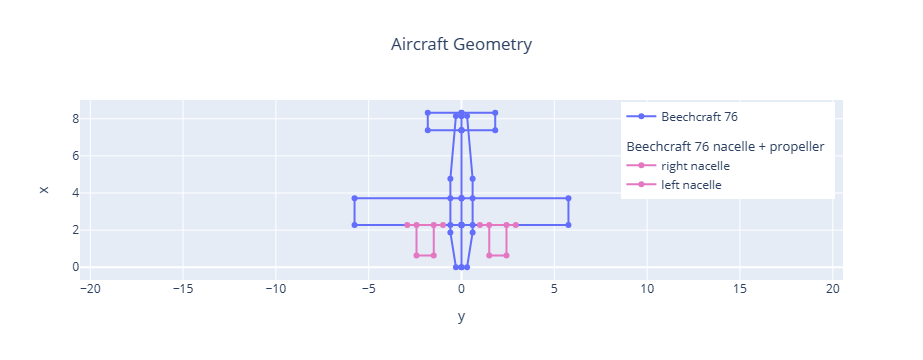

In [8]:
fig = api_plots.aircraft_geometry_plot(
    pth.join(WORK_FOLDER_PATH, "beechcraft_76_loads.xml"), name="Beechcraft 76"
)
fig.show()

## 2. Performing aerodynamic analysis
In this chapter we will see how to perform an aerodynamics analysis on the aircraft.

To do so, we will launch the aerodynamic coefficients computation using the same technique as previously mentionned on geometry.

In [9]:
# Define the option of the geometry module you want to use
# The openvsp_exe_path option might need to be deleted if the user doesn't have writing access
option_dict = {
    "propulsion_id": "fastga.wrapper.propulsion.basicIC_engine",
    "use_openvsp": True,
    "openvsp_exe_path": WORK_FOLDER_PATH,
    "compute_mach_interpolation": False,
    "compute_slipstream_cruise": True,
}

# Declare function on 1st geometry file
compute_aero = api_cs23.generate_block_analysis(
    "fastga.aerodynamics.legacy",
    [],
    str(AIRCRAFT_FILE),
    options=option_dict,
    overwrite=True,
)

2 Explicit Output(s) in 'system.aero_high.mach_interpolation_roskam.incompressible_conditions'

varname   val      
--------  ---------
mach      [0.05]   
reynolds  [500000.]


0 Implicit Output(s) in 'system.aero_high.mach_interpolation_roskam.incompressible_conditions'




In [10]:
# Compute both aircraft designs
result1 = compute_aero({})

# Open viewer
oad.variable_viewer(AIRCRAFT_FILE)

Chord ratio value outside of the range in Roskam's book, value clipped
Chord ratio value outside of the range in Roskam's book, value clipped


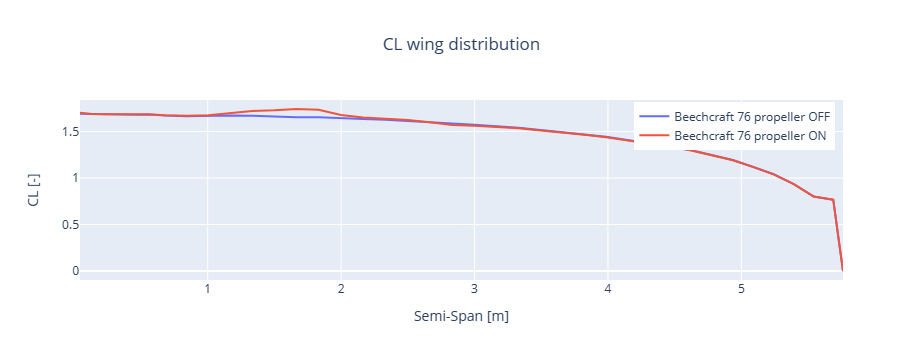

In [11]:
# Here we can verify the general shape of the  lift repartition on the wing and the values found in the
# mach interpolation
fig = api_plots.cl_wing_diagram(
    pth.join(WORK_FOLDER_PATH, "beechcraft_76_loads.xml"), name="Beechcraft 76"
)
fig = api_plots.cl_wing_diagram(
    pth.join(WORK_FOLDER_PATH, "beechcraft_76_loads.xml"),
    name="Beechcraft 76",
    fig=fig,
    prop_on=True,
)
fig.show()

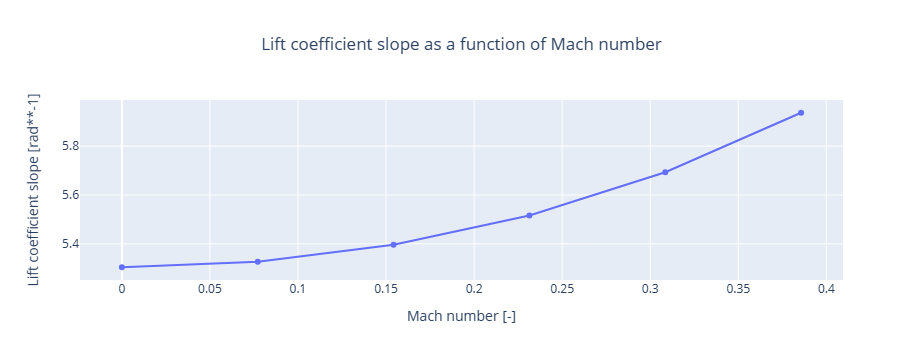

In [12]:
fig = api_plots.compressibility_effects_diagram(
    pth.join(WORK_FOLDER_PATH, "beechcraft_76_loads.xml"), name="Beechcraft 76"
)
fig.show()

Then, we will compute the most stringent loading case among the one we defined in the function (MTOW and Min fuel weight in the wing) so that we can then print out the shear stress and wing root bending moment. First we must compute the maximum level velocity at sea level as it is an input of the V-n diagrams computed during the wing loading computation process. Since this component alone is not registered as a module, we can't generate the block analysis using only an ID but we can use the component directly

In [13]:
from fastga.models.aerodynamics.load_factor import LoadFactor

var_inputs = ["data:weight:aircraft:MTOW", "data:weight:aircraft:MZFW"]

compute_load_factor = api_cs23.generate_block_analysis(
    LoadFactor(propulsion_id="fastga.wrapper.propulsion.basicIC_engine"),
    var_inputs,
    str(AIRCRAFT_FILE),
    overwrite=True,
)

In [14]:
inputs_dict = {
    "data:weight:aircraft:MTOW": (1769.0, "kg"),
    "data:weight:aircraft:MZFW": (1587.0, "kg"),
}

result1 = compute_load_factor(inputs_dict)

# Open viewer
oad.variable_viewer(AIRCRAFT_FILE)

For the loads however, we can go back to using ID's

In [15]:
var_inputs = [
    "data:weight:aircraft:CG:fwd:x",
    "data:weight:aircraft:CG:aft:x",
    "data:weight:aircraft_empty:CG:z",
    "data:weight:propulsion:engine:mass",
    "data:weight:airframe:landing_gear:main:mass",
    "data:weight:airframe:wing:mass",
    "data:mission:sizing:fuel",
    "data:weight:aircraft:MZFW",
    "data:weight:airframe:wing:punctual_mass:mass",
    "data:weight:airframe:wing:punctual_mass:y_ratio",
]

compute_wing_loads = api_cs23.generate_block_analysis(
    "fastga.loads.wing",
    var_inputs,
    str(AIRCRAFT_FILE),
    overwrite=True,
)

In [16]:
# Compute both aircraft designs using similar input parameters
inputs_dict = {
    "data:weight:aircraft:MZFW": (1531.6, "kg"),
    "data:weight:aircraft:CG:fwd:x": (2.76, "m"),
    "data:weight:aircraft:CG:aft:x": (3.09, "m"),
    "data:weight:aircraft_empty:CG:z": (1.197, "m"),
    "data:weight:propulsion:engine:mass": (351.84, "kg"),
    "data:weight:airframe:landing_gear:main:mass": (55.34, "kg"),
    "data:weight:airframe:wing:mass": (192.46, "kg"),
    "data:mission:sizing:fuel": (150.0, "kg"),
    "data:weight:airframe:wing:punctual_mass:mass": (0, "kg"),
    "data:weight:airframe:wing:punctual_mass:y_ratio": (0, None),
}

result1 = compute_wing_loads(inputs_dict)
# Open viewer
oad.variable_viewer(AIRCRAFT_FILE)

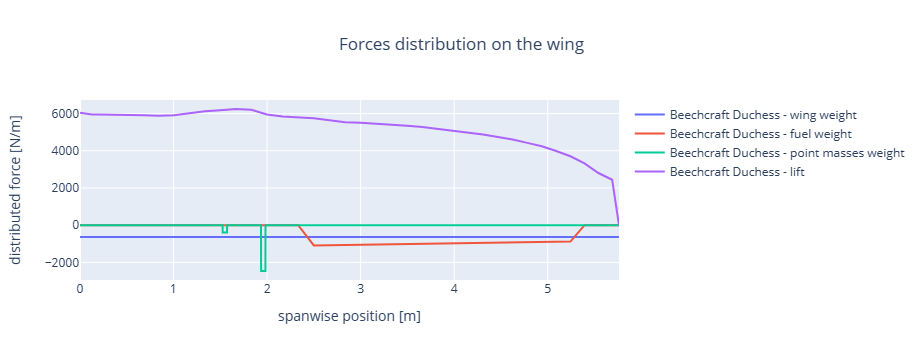

In [17]:
fig = api_plots.force_repartition_diagram(
    pth.join(WORK_FOLDER_PATH, "beechcraft_76_loads.xml"), name="Beechcraft Duchess"
)
fig.show()

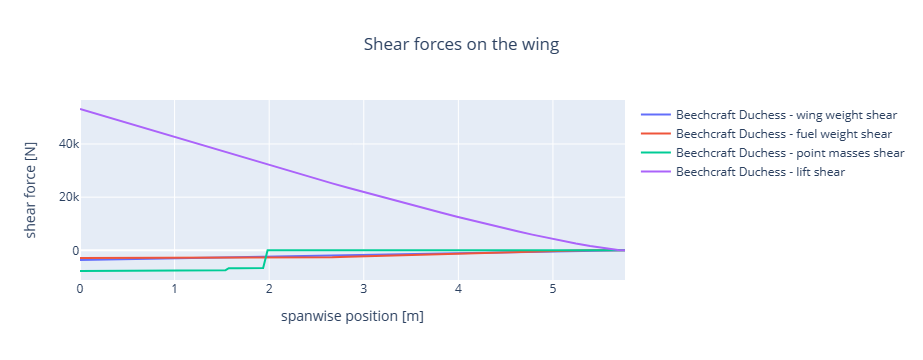

In [18]:
fig2 = api_plots.shear_diagram(
    pth.join(WORK_FOLDER_PATH, "beechcraft_76_loads.xml"), name="Beechcraft Duchess"
)
fig2.show()

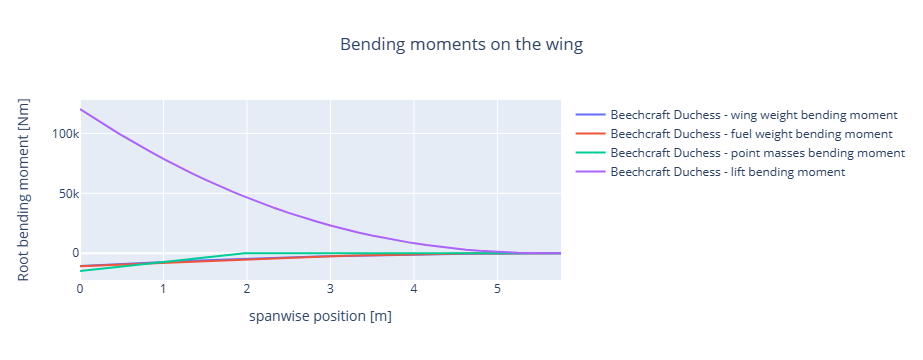

In [19]:
fig3 = api_plots.rbm_diagram(
    pth.join(WORK_FOLDER_PATH, "beechcraft_76_loads.xml"), name="Beechcraft Duchess"
)
fig3.show()